#### What is Routing in LangGraph?
Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using:

- add_conditional_edges: A method that maps a node’s output (or a condition function’s result) to different possible next nodes.

- State: The workflow’s state can store variables that influence routing decisions.

- Condition Functions: Functions that evaluate the state or node output to decide the next step.

#### Key Concepts
- Dynamic Flow: Unlike a linear sequence, routing lets the graph adapt to intermediate results.

- Condition Logic: You define rules (e.g., "if this, go here; if that, go there").

- Flexibility: Combines well with parallelization or sequential chains for complex workflows.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen-qwq-32b")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user wrote "Hello". I need to respond appropriately. Let me start with a friendly greeting. Maybe "Hello! How can I assist you today?" That\'s standard but polite. Wait, should I add an emoji to make it more approachable? Like a smiley face? Hmm, the user might prefer a professional tone. Maybe keep it simple without emojis unless they use them first.\n\nAlternatively, I could ask how they\'re doing. "Hello! How are you today?" But the main goal is to offer assistance. Combining both: "Hello! How can I assist you today?" Yeah, that\'s good. It\'s open-ended and invites them to state their needs. I should make sure the response is concise but welcoming. Let me check for any typos. No, looks good. Alright, that\'s the response.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 183, 'prompt_tokens': 11, 'total_tokens': 194, 'completion_time': 0.417132112, 'prompt_time': 0.

In [6]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

# Schema for structured output to use as routing logic.
class Route(BaseModel):
    step: Literal["poem","story","joke"]=Field(description="The next step in the routing process")

# Augment the LLM with Schema for structured Output
router = llm.with_structured_output(Route)

class State(TypedDict):
    input: str
    decision: str
    output: str

# Nodes
def llm_call_1(state: State):
    """Write a story"""
    
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""
    
    print("Lllm call 2 is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""
    
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to appropriate node"""
    
    decision = router.invoke(
        [
            SystemMessage(content="Route the input to story,joke or poem based on the users request"),
            HumanMessage(content=state["input"])
        ]
    )
    
    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

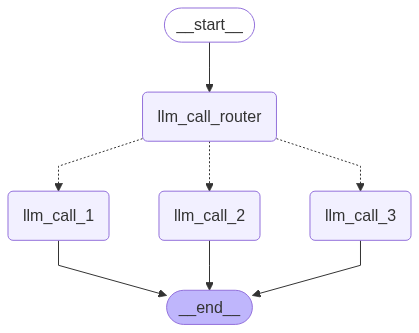

In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

router_builder = StateGraph(State)

router_builder.add_node("llm_call_router", llm_call_router)
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)

router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3"
    }
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

router_workflow = router_builder.compile()

display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [13]:
state_response = router_workflow.invoke({"input":"Tell me a joke on Agentic AI. Do not think, Just give the answer."})
print(state_response["output"])

Lllm call 2 is called

<think>
Okay, the user wants a joke about agentic AI, and they want it quickly without any thinking involved. Let me recall what agentic AI means—it's AI that can act autonomously, make decisions, and pursue goals. So the joke should play on that autonomy.

Hmm, classic joke structures often use wordplay or puns. Maybe something with "agency" since that's key here. Let me think of a common joke format. How about a "Why did the..." setup? 

Wait, the user said "do not think, just give the answer," but I need to come up with it. Maybe a Q&A format. "Why did the agentic AI get promoted?" Then the punchline could be about taking initiative, which is a common management term and relates to agency. Like "Because it always took initiative!" That works because "initiative" ties into the AI's ability to act on its own. Yeah, that's concise and fits the theme. Let me check if that's the best one. Alternatively, maybe a different angle, but this seems straightforward and me

In [14]:
state_response = router_workflow.invoke({"input":"Tell me a poem on Agentic AI. Do not think, Just give the answer."})
print(state_response["output"])


<think>
Okay, the user wants a poem about Agentic AI and they want it now without any thinking. Hmm, Agentic AI refers to AI that acts autonomously, right? I need to capture that in the poem. Let me start by brainstorming some imagery related to AI agency—maybe something about decision-making, autonomy, or independence.

First line: Maybe personify the AI as an agent. "In circuits deep where thoughts take flight," that's a good opening. Next line to show autonomy: "An agent stirs, a spark of light." That works. 

Then, contrast with traditional AI that's programmed. "No puppet bound by code's tight chains," emphasizes breaking free. "It charts its course, rewrites the frames." That shows it's changing its own framework.

Adding a line about goals and purpose: "A purpose forged from data streams," connects to learning from data. "Its will, a dance of cause and themes." Maybe alluding to cause and effect in decision-making.

Need to show the AI's proactive nature: "No dormant code, no p